## Reddit Post Classification using LSTM and TensorFlow 2.0
In this notebook, I will make use of LSTM's or Long Short Term Memory network to classify the reddit posts. In order to implement this, I will making use of TensorFlow 2.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#upgrade to TF 2.0
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 432kB/s 
     |████████████████████████████████| 3.8MB 31.5MB/s 
     |████████████████████████████████| 450kB 39.1MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [1]:
import re
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers

nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/clean_reddit_posts.csv')
df.head()

,Title,Body,SubReddit,Clean_Title,Clean_Body
0,What things about React annoy you the most?,"Can be anything: missing features, boilerplate...",reactjs,What things about React annoy you the most,Can be anything missing features boilerplate b...
1,Tutorial: Building a contacts manager using Vu...,missing,vuejs,Tutorial Building a contacts manager using Vue...,missing
2,Having trouble deciding what design pattern sh...,The structure of my project is the following:\...,vuejs,Having trouble deciding what design pattern sh...,The structure of my project is the following A...
3,Prettier rule for this?,I use Prettier and the auto format on save opt...,reactjs,Prettier rule for this,I use Prettier and the auto format on save opt...
4,Conditional Rendering in Vue JS - Beginner Tut...,missing,vuejs,Conditional Rendering in Vue JS Beginner Tutorial,missing


In [3]:
df = df.loc[:, ['Clean_Title', 'Clean_Body', 'SubReddit']]
df.head()

,Clean_Title,Clean_Body,SubReddit
0,What things about React annoy you the most,Can be anything missing features boilerplate b...,reactjs
1,Tutorial Building a contacts manager using Vue...,missing,vuejs
2,Having trouble deciding what design pattern sh...,The structure of my project is the following A...,vuejs
3,Prettier rule for this,I use Prettier and the auto format on save opt...,reactjs
4,Conditional Rendering in Vue JS Beginner Tutorial,missing,vuejs


In [0]:
df['Clean_Title'] = df['Clean_Title'].fillna('missing')
df['Clean_Body'] = df['Clean_Body'].fillna('missing')

In [0]:
df['Text'] = df['Clean_Title'] + ' ' + df['Clean_Body']

In [6]:
subreddit = {
    'reactjs': 0,
    'angular': 1,
    'vuejs': 2
}

df['SubReddit'] = df['SubReddit'].map(subreddit)
df['SubReddit'].value_counts(dropna=False)

1    993
0    953
2    871
Name: SubReddit, dtype: int64

In [0]:
def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens) 
    return filtered_text

In [0]:
df['Text'] = df['Text'].apply(remove_stopwords)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['SubReddit'], test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(2253,)
(564,)


In [0]:
NB_WORDS = 10000
MAX_LEN = 100
EPOCHS = 10
BATCH_SIZE = 64

In [11]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(df['Text'])
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Top 5 most common words are: [('angular', 1277), ('react', 1258), ('component', 1198), ('missing', 1139), ('vue', 1049)]


In [0]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [13]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    2253.000000
mean       45.389703
std        76.907287
min         2.000000
25%         8.000000
50%        24.000000
75%        56.000000
max      1915.000000
Name: Text, dtype: float64

In [0]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [0]:
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [19]:
model = models.Sequential()
model.add(layers.Embedding(NB_WORDS, 64, input_length=MAX_LEN))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 708,163
Trainable params: 708,163
Non-trainable params: 0
_________________________________________________________________


In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_train_seq_trunc, y_train_oh, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback],
                    validation_data=(X_test_seq_trunc, y_test_oh))

Train on 2253 samples, validate on 564 samples
Epoch 1/10
2253/2253 [==============================] - 11s 5ms/sample - loss: 1.0762 - accuracy: 0.4487 - val_loss: 1.0057 - val_accuracy: 0.6117
Epoch 2/10
2253/2253 [==============================] - 7s 3ms/sample - loss: 0.8058 - accuracy: 0.7261 - val_loss: 0.6341 - val_accuracy: 0.8138
Epoch 3/10
2253/2253 [==============================] - 7s 3ms/sample - loss: 0.4251 - accuracy: 0.8859 - val_loss: 0.4635 - val_accuracy: 0.8191
Epoch 4/10
2253/2253 [==============================] - 7s 3ms/sample - loss: 0.1711 - accuracy: 0.9605 - val_loss: 0.3859 - val_accuracy: 0.8404
Epoch 5/10
2253/2253 [==============================] - 7s 3ms/sample - loss: 0.0818 - accuracy: 0.9814 - val_loss: 0.4071 - val_accuracy: 0.8564
Epoch 6/10
2253/2253 [==============================] - 7s 3ms/sample - loss: 0.0484 - accuracy: 0.9889 - val_loss: 0.4703 - val_accuracy: 0.8511


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

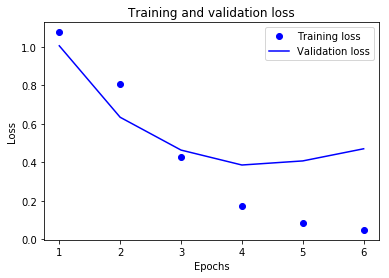

In [22]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

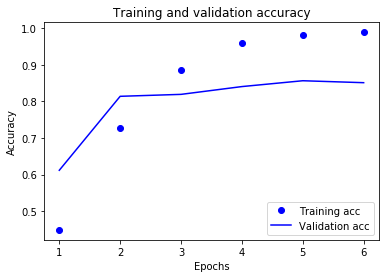

In [23]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()